In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
new = pd.read_csv('../training_data/resonant/ybafix_tmax_res.csv')
old = pd.read_csv('../training_data/resonant/ybaoldfeatures_res.csv')
labels = pd.read_csv('../training_data/resonant/yba_labels.csv')


In [11]:
new['MEGNO'].isna().sum()

11191

In [12]:
old['MEGNO'].isna().sum()

30421

In [13]:
dataset = pd.DataFrame.join(old,labels['Stable'])

In [15]:
dataset[features]

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd
0,0.060234,0.030043,0.000283,0.491222,0.504063,0.000882,0.000330,NaN,99.671099,21.854886
1,0.080547,0.017239,0.000138,0.432211,0.240504,0.008924,0.002141,0.008266,161.968909,40.989718
2,0.129660,0.028785,0.000989,1.000486,1.001981,0.000513,0.000936,0.010448,167.402468,51.758073
3,0.406112,0.038118,0.000942,0.348009,0.427768,0.035020,0.003593,0.012846,NaN,NaN
4,0.059897,0.026167,0.001919,0.285146,0.257596,0.052339,0.001386,0.032904,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
113538,0.082222,0.049940,0.016289,0.614960,0.664222,0.031330,0.003745,NaN,76.212769,21.217672
113539,0.251338,0.016063,0.002925,0.250122,0.272822,0.002159,0.000486,0.016374,61.260204,9.154976
113540,0.131799,0.027693,0.001458,0.660450,0.366664,0.067472,0.020413,0.005440,62.894058,20.937465
113541,0.209454,0.090838,0.010214,1.438882,0.395073,0.102280,0.038515,0.041145,63.330790,17.316868


In [4]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits
    #test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [5]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainX, trainY, testX, testY = train_test(dataset, features)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [6]:
trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]

In [7]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [8]:
test = XGBClassifier()
test.load_model('oldestspock.json')
#'featureclassifier.json'

[23:19:53] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


Text(0.5, 1.0, 'ROC curve (AUC = 0.836)')

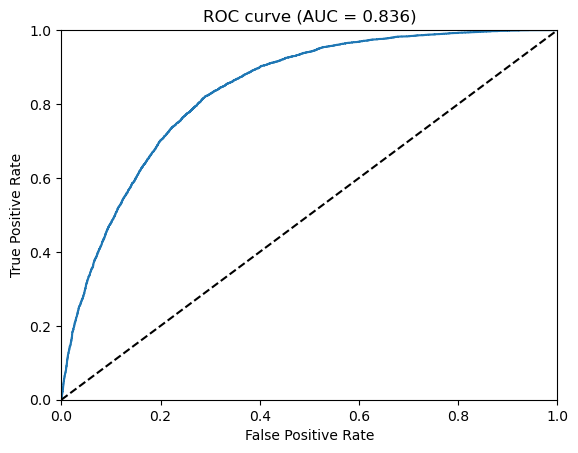

In [17]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(test, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))